In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Датасет

In [2]:
df = pd.read_csv("../data/features.csv", sep="|")
df.head()

,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency,is_insider
0,82.18,472.27,469.34,0.572792,86.31,478.56,502.38,7.696897,307.92,178.98,...,115.0,110.75,372.5,563.25,233.25,178.25,237.5,174.0,522.25,0
1,75.87,479.03,460.12,0.000000,0.00,0.00,0.00,4.770889,312.07,203.07,...,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0
2,94.25,477.76,422.48,0.201005,70.50,414.50,485.00,7.939698,261.86,142.48,...,149.0,92.00,984.0,975.00,120.00,124.00,133.0,67.0,336.00,0
3,10.33,556.47,514.17,6.126238,175.98,477.89,496.30,4.863861,469.23,223.51,...,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0
4,27.35,464.80,492.16,2.222222,153.42,510.17,413.58,2.962963,375.38,122.50,...,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0


In [3]:
y = df['is_insider']
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state = 0, test_size = 0.4)

In [4]:
medians = {} # словарь для хранения медиан для каждого столбца
# заполнение пустот в обучаемой выборке с помощью медиан
# и их использование для заполнения пустот в валидационной выборке
for col in x_train.columns:
    if col != 'is_insider':
        # медианы         
        medians[col + "_non_insider"] = x_train.loc[(x_train[col] != 0) & (x_train['is_insider'] == 0), col].median()
        medians[col + "_is_insider"] = x_train.loc[(x_train[col] != 0) & (x_train['is_insider'] == 1), col].median()
        # заполнение пустот в обучаемой выборке с помощью медиан из обучаемой выборки
        x_train.loc[(x_train[col] == 0) & (x_train['is_insider'] == 0), col] = medians[col + "_non_insider"] if medians[col + "_non_insider"] is not np.nan else 0 
        x_train.loc[(x_train[col] == 0) & (x_train['is_insider'] == 1), col] = medians[col + "_is_insider"] if medians[col + "_is_insider"] is not np.nan else 0
        # заполнение пустот в валидационной выборке с помощью медиан из обучаемой выборки
        x_test.loc[(x_test[col] == 0) & (x_test['is_insider'] == 0), col] = medians[col + "_non_insider"] if medians[col + "_non_insider"] is not np.nan else 0
        x_test.loc[(x_test[col] == 0) & (x_test['is_insider'] == 1), col] = medians[col + "_is_insider"] if medians[col + "_is_insider"] is not np.nan else 0
        
# очистка памяти
del medians

/Users/azamat/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
medians_insider = []
medians_non_insider = []
cols = []
special_keys = [
    "Key.esc",
    "Key.tab",
    "Key.caps_lock",
    "Key.shift",
    "Key.ctrl",
    "Key.alt",
    "Key.cmd",
    "Key.space",
    "Key.enter",
    "Key.backspace",
]
for col in x_train.columns:
    # не считаем медианы для таргета и частотных признаков
    if col != 'is_insider' and col not in special_keys:
        cols.append(col)
        medians_insider.append(x_train[x_train['is_insider'] == 1][col].median())
        medians_non_insider.append(x_train[x_train['is_insider'] == 0][col].median())   

In [6]:
rels = {
    "dwell": [0,0], # длительность нажатия первой буквы
    "interval": [0,0], # промежуток между отпусканием первой и нажатием второй буквы
    "flight": [0,0], # промежуток между нажатием первой и нажатием второй буквы
    "up_to_up": [0,0], # промежуток между отпусканием первой и отпусканием второй
    "dwell_first": [0,0], # длительность нажатия первой буквы
    "dwell_second": [0,0], # длительность нажатия второй буквы
    "dwell_third": [0,0], # длительность нажатия третьей буквы
    "interval_first": [0,0], # промежуток между отпусканием первой и нажатием второй буквы
    "interval_second": [0,0], # промежуток между отпусканием второй и нажатием третьей буквы
    "flight_first": [0,0], # промежуток между нажатием первой и нажатием второй буквы
    "flight_second": [0,0], # промежуток между нажатием второй и нажатием третьей буквы    
    "up_to_up_first": [0,0], # промежуток между отпусканием первой и отпусканием второй
    "up_to_up_second": [0,0], # промежуток между отпусканием второй и отпусканием третьей
    "latency": [0,0], # промежуток между нажатием первой и отпусканием третьей
}
for i in range(len(medians_insider)):
    for k,v in rels.items():
        if k in cols[i]:
            if medians_insider[i] < medians_non_insider[i]:
                v[0] += 1
            v[1] += 1

for k,v in rels.items():
    print(k,v[0],v[1],(v[1] - v[0]) / v[1] * 100)

dwell 43 58 25.862068965517242
interval 23 38 39.473684210526315
flight 28 38 26.31578947368421
up_to_up 19 30 36.666666666666664
dwell_first 15 20 25.0
dwell_second 15 20 25.0
dwell_third 7 10 30.0
interval_first 4 10 60.0
interval_second 6 10 40.0
flight_first 5 10 50.0
flight_second 7 10 30.0
up_to_up_first 6 10 40.0
up_to_up_second 6 10 40.0
latency 14 20 30.0


In [7]:
x_train.head()

,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency,is_insider
22,138.74,466.59,481.88,0.750136,145.065,401.835,457.255,3.428571,196.33,25.54,...,74.50,98.5,372.50,97.33,163.67,164.00,155.50,166.67,412.0,0
16,46.80,470.40,478.24,0.750136,145.065,401.835,457.255,3.193277,374.45,334.13,...,74.50,98.5,372.50,97.33,163.67,164.00,155.50,166.67,412.0,0
41,170.12,460.24,492.43,0.251046,87.000,927.000,14.000,4.518828,396.72,362.56,...,96.00,76.0,492.00,101.00,98.00,162.00,100.00,173.00,380.0,1
20,146.20,443.25,453.64,0.878049,89.250,374.830,380.750,3.951220,402.06,202.63,...,89.67,99.0,970.67,67.67,73.67,157.33,60.33,166.67,330.0,0
42,101.41,396.70,418.75,1.962258,99.065,556.535,155.600,5.844156,314.67,151.00,...,96.00,80.0,964.00,49.00,76.00,145.00,60.00,129.00,301.0,1


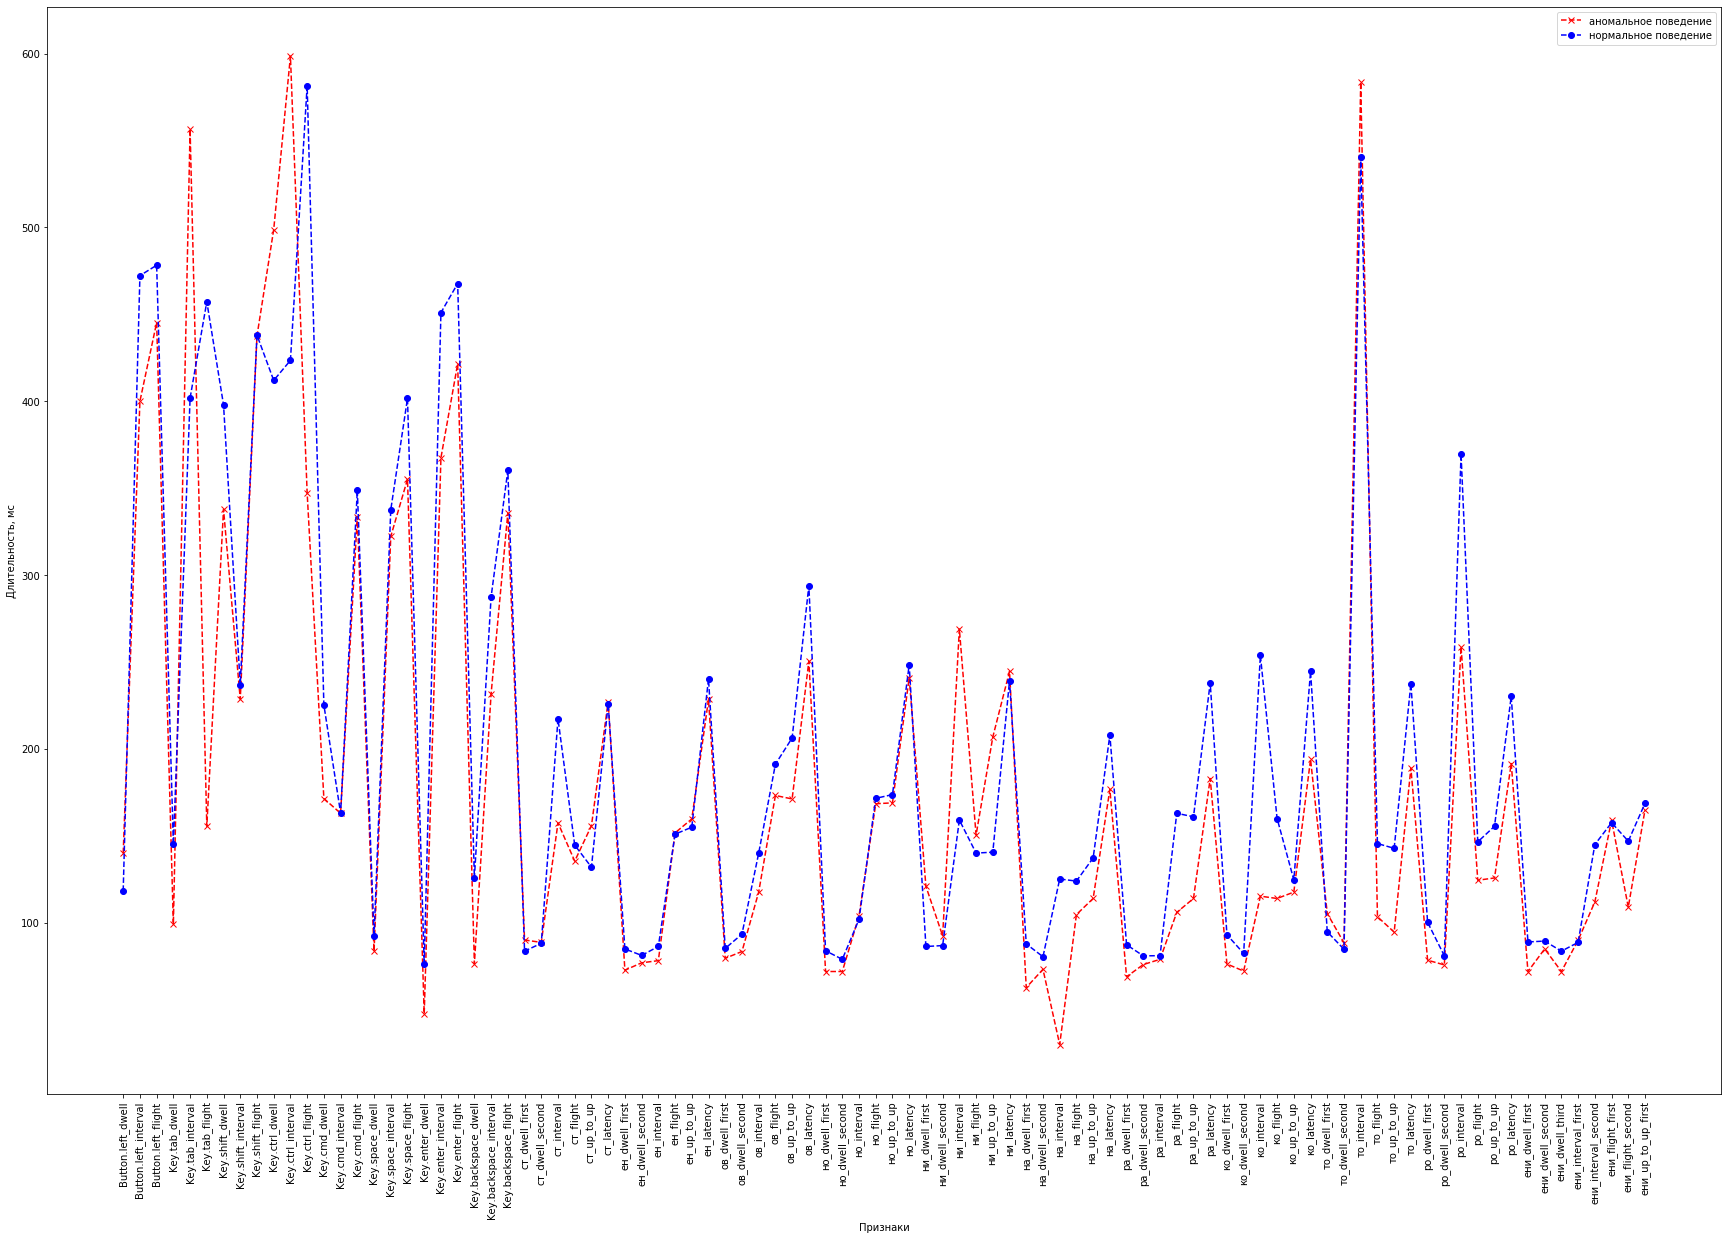

In [8]:
plt.figure(figsize=(30,20))
plt.plot(medians_insider[:92], '--rx', label = 'аномальное поведение')
plt.plot(medians_non_insider[:92], '--bo', label = 'нормальное поведение')
plt.legend()
plt.xticks(np.arange(len(cols)/2), labels=cols[:92], rotation=90)
plt.ylabel('Длительность, мс')
plt.xlabel('Признаки')
plt.savefig('first.png', bbox_inches='tight')
plt.show()

In [9]:
# удаление столбца is_insider из x_train и x_test
x_train.drop(columns = ['is_insider'], inplace = True)
x_test.drop(columns = ['is_insider'], inplace = True)
x_train.head()

/Users/azamat/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_first,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency
22,138.74,466.59,481.88,0.750136,145.065,401.835,457.255,3.428571,196.33,25.54,...,103.0,74.50,98.5,372.50,97.33,163.67,164.00,155.50,166.67,412.0
16,46.80,470.40,478.24,0.750136,145.065,401.835,457.255,3.193277,374.45,334.13,...,103.0,74.50,98.5,372.50,97.33,163.67,164.00,155.50,166.67,412.0
41,170.12,460.24,492.43,0.251046,87.000,927.000,14.000,4.518828,396.72,362.56,...,106.0,96.00,76.0,492.00,101.00,98.00,162.00,100.00,173.00,380.0
20,146.20,443.25,453.64,0.878049,89.250,374.830,380.750,3.951220,402.06,202.63,...,103.0,89.67,99.0,970.67,67.67,73.67,157.33,60.33,166.67,330.0
42,101.41,396.70,418.75,1.962258,99.065,556.535,155.600,5.844156,314.67,151.00,...,112.0,96.00,80.0,964.00,49.00,76.00,145.00,60.00,129.00,301.0


### Метрики 

In [10]:
def report(clf, x_train, y_train, x_test, y_test):
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    print("accuracy train:", clf.score(x_train,y_train), "accuracy test", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

### Модели

In [11]:
models = {
    'logistic regression': LogisticRegression(solver='lbfgs', random_state=0),
    'k-nearest neighbors': KNeighborsClassifier(n_neighbors=3),
    'naive bayes': BernoulliNB(),
    'support vector machines': SVC(kernel='linear', gamma='auto'),
    'random forest': RandomForestClassifier(max_depth=2, n_estimators = 200, random_state=0),
    'decision tree': DecisionTreeClassifier(),
    'adaptive boosting': AdaBoostClassifier(DecisionTreeClassifier(), algorithm="SAMME", n_estimators=200),
    'gradient boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=0),
    'multi-layer perceptron': MLPClassifier(alpha=0.1, max_iter=10000),
}

for k,v in models.items():
    print(k)
    report(v, x_train, y_train, x_test, y_test)

logistic regression
accuracy train: 1.0 accuracy test 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

k-nearest neighbors
accuracy train: 1.0 accuracy test 0.95
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.92      0.96        13

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20

naive bayes
accuracy train: 1.0 accuracy test 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        13

    accuracy   